### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 21 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 21 декабря, -4 балла после 08:30 28 декабря, -6 баллов после 08:30 04 янва, -8 баллов после 08:30 11 января.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Для убывания нужен антиградиент, поэтому возьмем градиенты со знаком минус

1. $ \triangledown Q_i = \triangledown L = 2(y_i - a(x_i))$


2. $ \triangledown Q_i = \triangledown L = y_i * exp(-a(x_i)y_i) $


3. $ \triangledown Q_i = \triangledown L = \frac{y_i}{1 + exp(-a(x_i)y_i)} * exp(-a(x_i)y_i) $



##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [4]:
class MyGradientBoostingClassifier:

    def __init__(self, loss, learning_rate, n_estimators, colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов: 'mse', 'exp', 'log'
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        
        self.losses = {
            'mse' : self.mse_grad,
            'exp' : self.exp_grad,
            'log' : self.log_grad,
        }
        self.loss = self.losses[loss]
        
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.estimators = []
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        
        class pass_model:
            def __init__(self):
                pass
            def fit(self, X, y):
                self.y = y
            def predict(self, X):
                return [np.mean(y)] * X.shape[0]
        
        if init_model is None:
            self.estimators = [pass_model()]
        else:
            self.estimators = [init_model]
            
        self.n_classes = np.max(y)
        
        self.estimators[0].fit(X, y)
        y_pred = np.array(self.estimators[0].predict(X), dtype=float)
        
        for i in range(self.n_estimators):
            
            sub_ind = np.random.choice(np.arange(X.shape[0]), int(self.subsample * X.shape[0]), replace=False)
            col_ind = np.random.choice(np.arange(X.shape[1]), int(self.colsample * X.shape[1]), replace=False)
            X_sampled = X[sub_ind]
            y_pred_sampled = y_pred[sub_ind]
            y_sampled = y[sub_ind]
            
            gq = self.loss(y_sampled, y_pred_sampled)
            
            model = base_model(max_features=self.colsample, *self.args, **self.kwargs)
            model.fit(X_sampled, gq)
            self.estimators.append(model)
            
            y_pred += self.learning_rate * model.predict(X)
        
    def predict(self, X):
        y_pred = np.asarray(self.estimators[0].predict(X), dtype=np.float64)
        for model in self.estimators[1:]:
            y_pred += model.predict(X) * self.learning_rate
            
        return np.clip(np.around(y_pred).astype(np.int16), 0, self.n_classes)
    
       
    def predict_proba(self, X):
        y_pred = self.estimators[0].predict(X)
        for model in self.estimators[1:]:
            y_pred += model.predict(X) * self.learning_rate
            
        return y_pred

    @staticmethod
    def mse_grad(yi, ai):
        return 2 * (yi - ai)
    
    
    @staticmethod
    def exp_grad(yi, ai):
        return yi * np.exp(-ai * yi)
    
    
    @staticmethod
    def log_grad(yi, ai):
        return yi * np.exp(-ai * yi) / (1 + np.exp(-ai * yi))

In [27]:
my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.2, n_estimators=10, subsample=0.2,
                                      max_depth=3, colsample=0.5)
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=10, subsample=0.7, max_features=0.8)

In [28]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [29]:
my_clf.fit(X_train, y_train, DecisionTreeRegressor)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
1.0


In [30]:
print(clf.predict(X_test))
print(my_clf.predict(X_test))
print(my_clf.predict_proba(X_test))

[0 0 1 1 2 1 0 2 0 2 1 1 1 1 2 1 0 2]
[0 0 1 1 2 0 0 2 0 2 1 1 1 1 2 1 0 2]
[0.07473641 0.40679788 1.03649122 0.83411389 1.87086698 0.2774693
 0.07473641 2.15973337 0.14026351 2.36825898 1.00401116 1.27646169
 1.2666333  0.89128551 1.58277012 1.11233214 0.12187037 2.31348757]


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [31]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [32]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [33]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


### Точность от числа итераций:

In [34]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from tqdm import tqdm

100%|██████████| 20/20 [01:22<00:00,  4.13s/it]


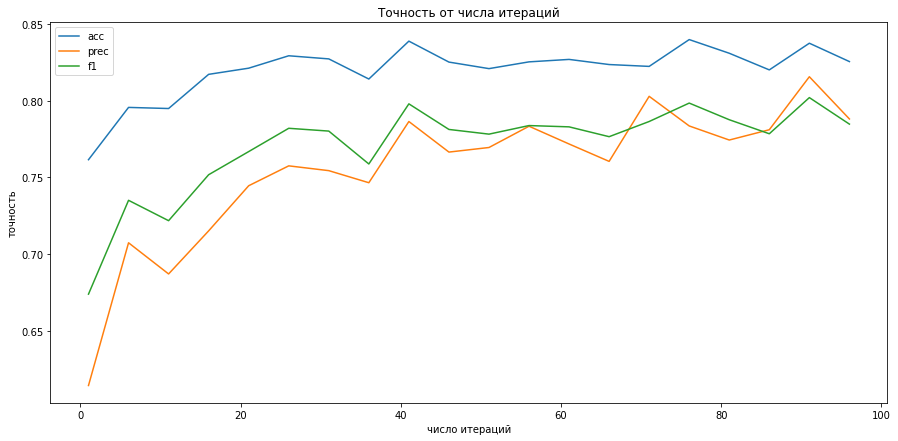

In [35]:
plt.figure(figsize=(15,7))
plt.xlabel('число итераций')
plt.ylabel('точность')
plt.title('Точность от числа итераций')

n_iters = np.arange(1, 100, 5)
acc = []
prec = []
f1 = []

kf = KFold(n_splits=5)

for n_iter in tqdm(n_iters):
    t_acc, t_prec, t_f1 = [], [], []
    
    for train_index, test_index in kf.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[test_index], y[test_index]
        
        my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.2, n_estimators=n_iter, subsample=0.6,
                                          max_depth=3, colsample=0.7)
        my_clf.fit(X_train, y_train)
        y_pred = my_clf.predict(X_val)
        
        t_acc.append( accuracy_score(y_pred, y_val) )
        t_prec.append( precision_score(y_pred, y_val) )
        t_f1.append( f1_score(y_pred, y_val) )
    
    acc.append(np.mean(t_acc))
    prec.append(np.mean(t_prec))
    f1.append(np.mean(t_f1))

plt.plot(n_iters, acc, label='acc')
plt.plot(n_iters, prec, label='prec')
plt.plot(n_iters, f1, label='f1')

plt.legend()

100%|██████████| 3/3 [00:05<00:00,  1.90s/it]

['mse', 'exp', 'log']
[0.820203488372093, 0.42306201550387595, 0.4457848837209301]
[0.7508559191723813, 0.9999077490774908, 0.9981798779823328]
[0.7695836800904688, 0.5870520567248122, 0.5976618699298317]


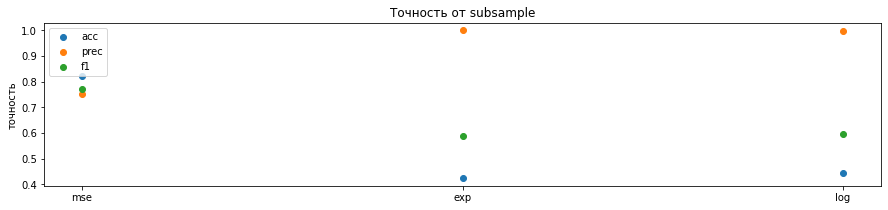

In [37]:
plt.figure(figsize=(15,3))
plt.xlabel('')
plt.ylabel('точность')
plt.title('Точность от subsample')

losses = ['mse', 'exp', 'log']
acc = []
prec = []
f1 = []

kf = KFold(n_splits=5)

for loss in tqdm(losses):
    t_acc, t_prec, t_f1 = [], [], []
    
    for train_index, test_index in kf.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[test_index], y[test_index]
        
        my_clf = MyGradientBoostingClassifier(loss, learning_rate=0.15, n_estimators=20, subsample=0.6,
                                          max_depth=3, colsample=0.7)
        my_clf.fit(X_train, y_train)
        y_pred = my_clf.predict(X_val)
        
        t_acc.append( accuracy_score(y_pred, y_val) )
        t_prec.append( precision_score(y_pred, y_val) )
        t_f1.append( f1_score(y_pred, y_val) )
    
    acc.append(np.mean(t_acc))
    prec.append(np.mean(t_prec))
    f1.append(np.mean(t_f1))
    
print(losses)
print(acc)
print(prec)
print(f1)

arg = ['mse', 'exp', 'log']

plt.scatter(arg, acc, label='acc')
plt.scatter(arg, prec, label='prec')
plt.scatter(arg, f1, label='f1')

plt.legend()

Выбираем mse.

### Подбираем learning rate

100%|██████████| 12/12 [00:21<00:00,  1.82s/it]

0.3 0.8304748062015503
0.2 0.7690026826505463
0.3 0.7837902254576001


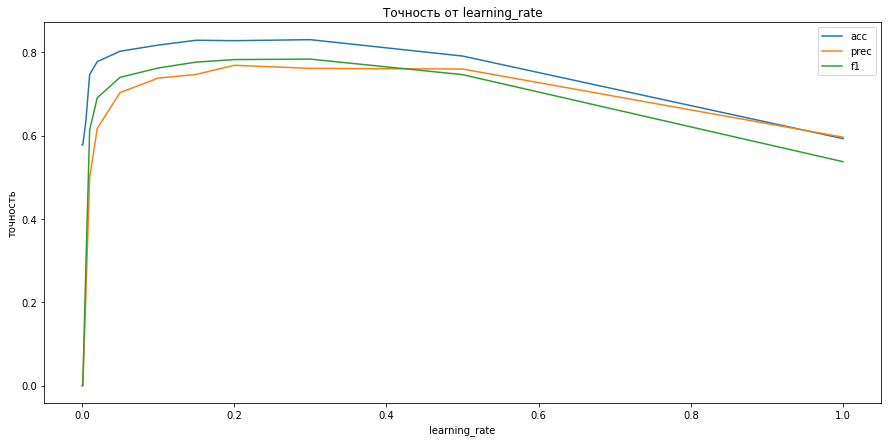

In [38]:
plt.figure(figsize=(15,7))
plt.xlabel('learning_rate')
plt.ylabel('точность')
plt.title('Точность от learning_rate')

lrs = [0.0001, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1]
acc = []
prec = []
f1 = []

kf = KFold(n_splits=5)

for lr in tqdm(lrs):
    t_acc, t_prec, t_f1 = [], [], []
    
    for train_index, test_index in kf.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[test_index], y[test_index]
        
        my_clf = MyGradientBoostingClassifier('mse', learning_rate=lr, n_estimators=20, subsample=0.6,
                                          max_depth=3, colsample=0.7)
        my_clf.fit(X_train, y_train)
        y_pred = my_clf.predict(X_val)
        
        t_acc.append( accuracy_score(y_pred, y_val) )
        t_prec.append( precision_score(y_pred, y_val) )
        t_f1.append( f1_score(y_pred, y_val) )
    
    acc.append(np.mean(t_acc))
    prec.append(np.mean(t_prec))
    f1.append(np.mean(t_f1))

plt.plot(lrs, acc, label='acc')
plt.plot(lrs, prec, label='prec')
plt.plot(lrs, f1, label='f1')

print(lrs[np.argmax(acc)], np.max(acc))
print(lrs[np.argmax(prec)], np.max(prec))
print(lrs[np.argmax(f1)], np.max(f1))

plt.legend()

### Подбираем subsample

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

0.1 0.8326550387596899
0.1 0.7650468142562994
0.1 0.7865256747854843


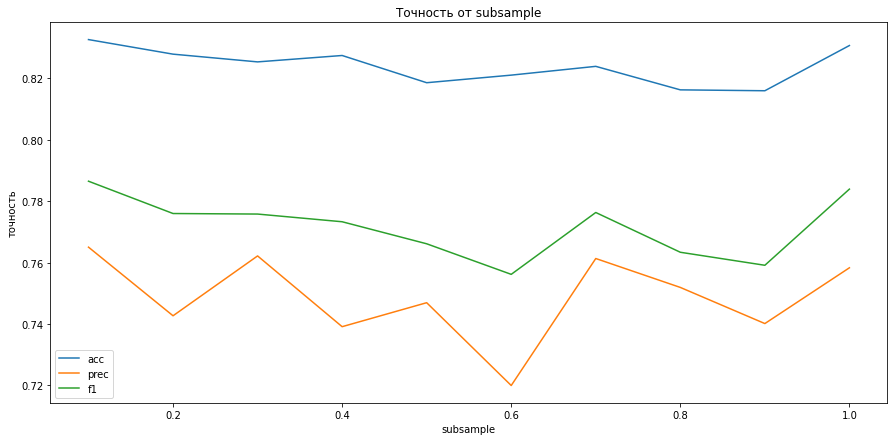

In [39]:
plt.figure(figsize=(15,7))
plt.xlabel('subsample')
plt.ylabel('точность')
plt.title('Точность от subsample')

sss = np.linspace(0.1, 1, 10)
acc = []
prec = []
f1 = []

kf = KFold(n_splits=5)

for ss in tqdm(sss):
    t_acc, t_prec, t_f1 = [], [], []
    
    for train_index, test_index in kf.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[test_index], y[test_index]
        
        my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.15, n_estimators=20, subsample=ss,
                                          max_depth=3, colsample=0.7)
        my_clf.fit(X_train, y_train)
        y_pred = my_clf.predict(X_val)
        
        t_acc.append( accuracy_score(y_pred, y_val) )
        t_prec.append( precision_score(y_pred, y_val) )
        t_f1.append( f1_score(y_pred, y_val) )
    
    acc.append(np.mean(t_acc))
    prec.append(np.mean(t_prec))
    f1.append(np.mean(t_f1))

plt.plot(sss, acc, label='acc')
plt.plot(sss, prec, label='prec')
plt.plot(sss, f1, label='f1')

print(sss[np.argmax(acc)], np.max(acc))
print(sss[np.argmax(prec)], np.max(prec))
print(sss[np.argmax(f1)], np.max(f1))

plt.legend()

### Подбираем colsample

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]

0.6 0.828391472868217
0.6 0.7643081622710007
0.6 0.7819416628201867


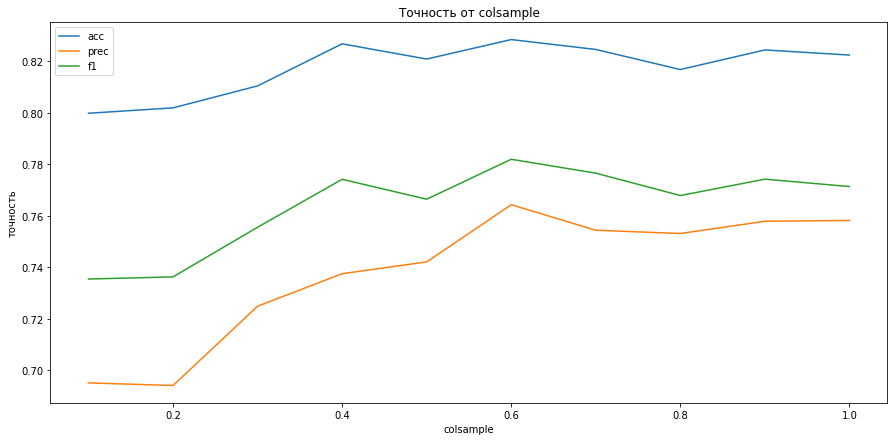

In [40]:
plt.figure(figsize=(15,7))
plt.xlabel('colsample')
plt.ylabel('точность')
plt.title('Точность от colsample')

css = np.linspace(0.1, 1, 10)
acc = []
prec = []
f1 = []

kf = KFold(n_splits=5)

for cs in tqdm(css):
    t_acc, t_prec, t_f1 = [], [], []
    
    for train_index, test_index in kf.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[test_index], y[test_index]
        
        my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.15, n_estimators=20, subsample=0.4,
                                          colsample=cs, max_depth=3)
        my_clf.fit(X_train, y_train)
        y_pred = my_clf.predict(X_val)
        
        t_acc.append( accuracy_score(y_pred, y_val) )
        t_prec.append( precision_score(y_pred, y_val) )
        t_f1.append( f1_score(y_pred, y_val) )
    
    acc.append(np.mean(t_acc))
    prec.append(np.mean(t_prec))
    f1.append(np.mean(t_f1))

plt.plot(css, acc, label='acc')
plt.plot(css, prec, label='prec')
plt.plot(css, f1, label='f1')

print(css[np.argmax(acc)], np.max(acc))
print(css[np.argmax(prec)], np.max(prec))
print(css[np.argmax(f1)], np.max(f1))

plt.legend()

### Подбираем max_depth для деревьев

100%|██████████| 14/14 [00:29<00:00,  2.11s/it]

3 0.83125
13 0.7726516105495951
3 0.7824120445052415


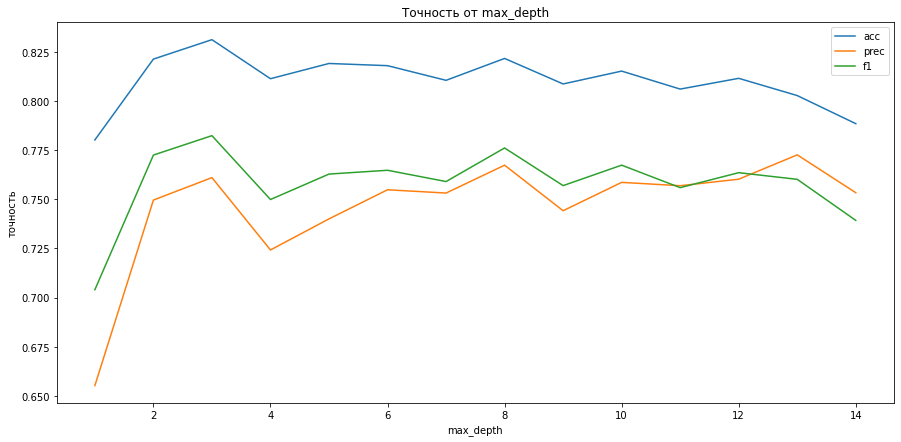

In [41]:
plt.figure(figsize=(15,7))
plt.xlabel('max_depth')
plt.ylabel('точность')
plt.title('Точность от max_depth')

mds = np.arange(1, 15)
acc = []
prec = []
f1 = []

kf = KFold(n_splits=5)

for md in tqdm(mds):
    t_acc, t_prec, t_f1 = [], [], []
    
    for train_index, test_index in kf.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[test_index], y[test_index]
        
        my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.15, n_estimators=20, subsample=0.4,
                                          colsample=0.6, max_depth=md)
        my_clf.fit(X_train, y_train)
        y_pred = my_clf.predict(X_val)
        
        t_acc.append( accuracy_score(y_pred, y_val) )
        t_prec.append( precision_score(y_pred, y_val) )
        t_f1.append( f1_score(y_pred, y_val) )
    
    acc.append(np.mean(t_acc))
    prec.append(np.mean(t_prec))
    f1.append(np.mean(t_f1))

plt.plot(mds, acc, label='acc')
plt.plot(mds, prec, label='prec')
plt.plot(mds, f1, label='f1')

print(mds[np.argmax(acc)], np.max(acc))
print(mds[np.argmax(prec)], np.max(prec))
print(mds[np.argmax(f1)], np.max(f1))

plt.legend()

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [42]:
from sklearn.ensemble import RandomForestRegressor

### Boo

In [57]:
acc = []
prec = []
f1 = []

for train_index, test_index in tqdm(kf.split(X, y)):
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[test_index], y[test_index]

    my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.15, n_estimators=20, subsample=0.4,
                                      colsample=0.6, max_depth=3)
    my_clf.fit(X_train, y_train, DecisionTreeRegressor)
    y_pred = my_clf.predict(X_val)

    acc.append( accuracy_score(y_pred, y_val) )
    prec.append( precision_score(y_pred, y_val) )
    f1.append( f1_score(y_pred, y_val) )

print('accuracy:', np.mean(acc))
print('precision:', np.mean(prec))
print('f1:', np.mean(f1))

5it [00:01,  4.33it/s]

accuracy: 0.8189922480620154
precision: 0.7215482750235178
f1: 0.7561376549653096


### BooBag

In [58]:
acc = []
prec = []
f1 = []

for train_index, test_index in tqdm(kf.split(X, y)):
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[test_index], y[test_index]

    my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.15, n_estimators=20, subsample=0.4,
                                      colsample=0.6, max_depth=3)
    my_clf.fit(X_train, y_train, RandomForestRegressor)
    y_pred = my_clf.predict(X_val)

    acc.append( accuracy_score(y_pred, y_val) )
    prec.append( precision_score(y_pred, y_val) )
    f1.append( f1_score(y_pred, y_val) )

print('accuracy:', np.mean(acc))
print('precision:', np.mean(prec))
print('f1:', np.mean(f1))

5it [01:15, 15.16s/it]

accuracy: 0.8310562015503876
precision: 0.7523578166173911
f1: 0.7806357976814168


### BagBoo

In [45]:
acc = []
prec = []
f1 = []

for train_index, test_index in tqdm(kf.split(X, y)):
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[test_index], y[test_index]

    predictions = []
    for k in range(10):
        sub_ind = np.random.choice(np.arange(X_train.shape[0]), int(0.6 * X_train.shape[0]), replace=False)

        Xb = X_train[sub_ind]
        yb = y_train[sub_ind]
        
        my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.15, n_estimators=20, subsample=0.4,
                                          colsample=0.6, max_depth=3)
        my_clf.fit(Xb, yb)
        y_pred = my_clf.predict(X_val)

        predictions.append(y_pred)
     
    nz = np.count_nonzero(predictions, axis=0)
    z = len(predictions) - nz
    y_pred = np.where(z >= nz, 0, 1)
    
    acc.append( accuracy_score(y_pred, y_val) )
    prec.append( precision_score(y_pred, y_val) )
    f1.append( f1_score(y_pred, y_val) )

print('accuracy:', np.mean(acc))
print('precision:', np.mean(prec))
print('f1:', np.mean(f1))

5it [00:06,  1.31s/it]

accuracy: 0.8311531007751938
precision: 0.7368536284155229
f1: 0.7773556759936053


Как можно увидеть, качество подросло. Это может происходить из-за грамотного комбинирования работы с bias и variance: бэггинг сохраняет bias, уменьшает variance; бустинг - уменьшает bias, оставляет или увеличивает variance, поэтому в совокупности эти подходы приводят к снижению обеих компонент, тем самым увеличивая точность.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



### Mean init

In [46]:
acc = []
prec = []
f1 = []

for train_index, test_index in tqdm(kf.split(X, y)):
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[test_index], y[test_index]

    my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.15, n_estimators=20, subsample=0.4,
                                      colsample=0.6, max_depth=3)
    my_clf.fit(X_train, y_train, DecisionTreeRegressor)
    y_pred = my_clf.predict(X_val)

    acc.append( accuracy_score(y_pred, y_val) )
    prec.append( precision_score(y_pred, y_val) )
    f1.append( f1_score(y_pred, y_val) )

print('accuracy:', np.mean(acc))
print('precision:', np.mean(prec))
print('f1:', np.mean(f1))

5it [00:01,  4.48it/s]

accuracy: 0.8214631782945737
precision: 0.7474978322374068
f1: 0.7700422970829068


### Linear init

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
acc = []
prec = []
f1 = []

for train_index, test_index in tqdm(kf.split(X, y)):
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[test_index], y[test_index]

    my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.15, n_estimators=20, subsample=0.4,
                                      colsample=0.6, max_depth=3)
    my_clf.fit(X_train, y_train, DecisionTreeRegressor, LinearRegression())
    y_pred = my_clf.predict(X_val)

    acc.append( accuracy_score(y_pred, y_val) )
    prec.append( precision_score(y_pred, y_val) )
    f1.append( f1_score(y_pred, y_val) )

print('accuracy:', np.mean(acc))
print('precision:', np.mean(prec))
print('f1:', np.mean(f1))

5it [00:01,  4.08it/s]

accuracy: 0.8335271317829458
precision: 0.809071480883012
f1: 0.7949307670533331


### Random forest

In [49]:
from sklearn.ensemble import RandomForestRegressor

In [50]:
acc = []
prec = []
f1 = []

for train_index, test_index in tqdm(kf.split(X, y)):
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[test_index], y[test_index]

    my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.15, n_estimators=20, subsample=0.4,
                                      colsample=0.6, max_depth=3)
    my_clf.fit(X_train, y_train, DecisionTreeRegressor, RandomForestRegressor())
    y_pred = my_clf.predict(X_val)

    acc.append( accuracy_score(y_pred, y_val) )
    prec.append( precision_score(y_pred, y_val) )
    f1.append( f1_score(y_pred, y_val) )

print('accuracy:', np.mean(acc))
print('precision:', np.mean(prec))
print('f1:', np.mean(f1))

5it [00:48,  9.71s/it]

accuracy: 0.8407945736434108
precision: 0.7628865384538479
f1: 0.7913497623394674


### SVM

In [51]:
from sklearn.svm import SVC, SVR

In [52]:
acc = []
prec = []
f1 = []

for train_index, test_index in tqdm(kf.split(X, y)):
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[test_index], y[test_index]

    my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.15, n_estimators=20, subsample=0.4,
                                      colsample=0.6, max_depth=3)
    my_clf.fit(X_train, y_train, DecisionTreeRegressor, SVC())
    y_pred = my_clf.predict(X_val)

    acc.append( accuracy_score(y_pred, y_val) )
    prec.append( precision_score(y_pred, y_val) )
    f1.append( f1_score(y_pred, y_val) )

print('accuracy:', np.mean(acc))
print('precision:', np.mean(prec))
print('f1:', np.mean(f1))

5it [01:25, 17.19s/it]

accuracy: 0.8204457364341085
precision: 0.747024870511647
f1: 0.7694538435389957


In [53]:
acc = []
prec = []
f1 = []

for train_index, test_index in tqdm(kf.split(X, y)):
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[test_index], y[test_index]

    my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.15, n_estimators=20, subsample=0.4,
                                      colsample=0.6, max_depth=3)
    my_clf.fit(X_train, y_train, DecisionTreeRegressor, SVR())
    y_pred = my_clf.predict(X_val)

    acc.append( accuracy_score(y_pred, y_val) )
    prec.append( precision_score(y_pred, y_val) )
    f1.append( f1_score(y_pred, y_val) )

print('accuracy:', np.mean(acc))
print('precision:', np.mean(prec))
print('f1:', np.mean(f1))

5it [01:26, 17.26s/it]

accuracy: 0.8219476744186046
precision: 0.7477640859707566
f1: 0.7694946544994841


### LightGBM

In [54]:
from lightgbm import LGBMClassifier, LGBMRegressor

In [55]:
acc = []
prec = []
f1 = []

for train_index, test_index in tqdm(kf.split(X, y)):
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[test_index], y[test_index]

    my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.15, n_estimators=20, subsample=0.4,
                                      colsample=0.6, max_depth=3)
    my_clf.fit(X_train, y_train, DecisionTreeRegressor, LGBMClassifier())
    y_pred = my_clf.predict(X_val)

    acc.append( accuracy_score(y_pred, y_val) )
    prec.append( precision_score(y_pred, y_val) )
    f1.append( f1_score(y_pred, y_val) )

print('accuracy:', np.mean(acc))
print('precision:', np.mean(prec))
print('f1:', np.mean(f1))

5it [00:02,  1.85it/s]

accuracy: 0.8481104651162792
precision: 0.7915125377323655
f1: 0.807857469160362


In [56]:
acc = []
prec = []
f1 = []

for train_index, test_index in tqdm(kf.split(X, y)):
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[test_index], y[test_index]

    my_clf = MyGradientBoostingClassifier('mse', learning_rate=0.15, n_estimators=20, subsample=0.4,
                                      colsample=0.6, max_depth=3)
    my_clf.fit(X_train, y_train, DecisionTreeRegressor, LGBMRegressor())
    y_pred = my_clf.predict(X_val)

    acc.append( accuracy_score(y_pred, y_val) )
    prec.append( precision_score(y_pred, y_val) )
    f1.append( f1_score(y_pred, y_val) )

print('accuracy:', np.mean(acc))
print('precision:', np.mean(prec))
print('f1:', np.mean(f1))

5it [00:02,  1.97it/s]

accuracy: 0.8422480620155038
precision: 0.7936809767542414
f1: 0.8022487235019063


Каждый из алгоритмов поднял скор, а если смотреть на LightGBM - то очень существенно. Дело в более адекватном начальном приближении(соответствующем действительной природе данных), для которого бустинг далее уже именно исправляет ошибку, а не перестраивает начальное приближение до похожнего на правду состояния.

## Фидбек (бесценно)

Очень долго не мог понять, что такое бустинг. Не понимал до тех пор, пока не дошёл тот момент, что в общем-то на самих данных мы обучаемся один раз, а все следующие разы - на ошибках в предсказаниях(инициализация вообще никак не отделялась от следующих итераций); также очень долго не понимал, что значит "обучаемся на ошибках", сколько бы раз не видел и не слышал эту фразу, пока не понял, что мы подменяем таргет(с того что было в постановке на ошибку), и хотим добить каждой следующей моделью "остаток" до таргета из постановки задачи(после слайда со сложением моделей, было ощущение что мы делаем предикт на уровне 3 + 2 + 2 + 3(то есть слагаемые все вносят существенный вклад, наверное так), а на самом деле тут скорее 8 + 1.5 + 0.4 + 0.1). 